Try to enable TPU 


## Load the data we will use:




In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Allows for checkpoints to be stored in google drive (Not sure we need this)

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')
checkpoints = '/content/drive/MyDrive/colab_files/birds/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

Mounted at /content/drive


In [ ]:
!rm -rf birds23wi/


In [4]:
from matplotlib.lines import ls_mapper_r
import os

if not os.path.exists('birds23wi'):
    !mkdir birds23wi
    os.chdir('birds23wi')

    !wget https://pjreddie.com/media/files/birds/train.tar
    !wget https://pjreddie.com/media/files/birds/test.tar
    !wget https://pjreddie.com/media/files/birds/names.txt
    !tar xf train.tar
    !tar xf test.tar
    !mkdir testing
    !mv test testing
    os.chdir('..')




--2023-03-10 23:26:51--  https://pjreddie.com/media/files/birds/train.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7970048512 (7.4G) [application/octet-stream]
Saving to: ‘train.tar’

train.tar           100%[===================>]   7.42G  58.1MB/s    in 2m 18s  

2023-03-10 23:29:10 (54.9 MB/s) - ‘train.tar’ saved [7970048512/7970048512]

--2023-03-10 23:29:10--  https://pjreddie.com/media/files/birds/test.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2057210880 (1.9G) [application/octet-stream]
Saving to: ‘test.tar’

test.tar            100%[===================>]   1.92G  66.2MB/s    in 32s     

2023-03-10 23:29:43 (61.1 MB/s) - ‘test.tar’ saved [2057210880/2057210880]

--2023-03-10 23:29:43--  https:

In [ ]:
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/kaggle/kaggle.json" ~/.kaggle/



In [ ]:
!kaggle competitions download -c birds23wi

In [5]:
def get_bird_data(augmentation=0):
    if (augmentation == 1):
      transform_train = transforms.Compose([
          transforms.Resize(128),
          transforms.RandomCrop(128, padding=8, padding_mode='edge'), # Take 128x128 crops from padded images
          transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
          transforms.ToTensor(),
      ])
    elif augmentation == 2: ## color jitter
      transform_train = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(size=224, scale=(0.5, 1.0)),
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      ])
    else:
      transform_train = transforms.ToTensor()

    transform_test = transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
    ])

    trainset = torchvision.datasets.ImageFolder(root='birds23wi/train', transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

    testset = torchvision.datasets.ImageFolder(root='birds23wi/testing', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    classes = open("birds23wi/names.txt").read().strip().split("\n")
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data(2)

In [ ]:
dataiter = iter(data['train'])
images, labels = next(dataiter)
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(8)))


In [6]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses

# Resnet 18



In [ ]:
device = torch.device("cuda")
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 555) # This will reinitialize the layer as well


losses = train(resnet, data['train'], epochs=5, lr=.01, print_every=10, checkpoint_path=checkpoints + " resnet18v2")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


[0,    10] loss: 6.511
[0,    20] loss: 6.439
[0,    30] loss: 6.326
[0,    40] loss: 6.196
[0,    50] loss: 6.012
[0,    60] loss: 5.775
[0,    70] loss: 5.616
[0,    80] loss: 5.478
[0,    90] loss: 5.249
[0,   100] loss: 5.129
[0,   110] loss: 4.929
[0,   120] loss: 4.808
[0,   130] loss: 4.703
[0,   140] loss: 4.545
[0,   150] loss: 4.486
[0,   160] loss: 4.358
[0,   170] loss: 4.337
[0,   180] loss: 4.237
[0,   190] loss: 4.018
[0,   200] loss: 4.102
[0,   210] loss: 4.055
[0,   220] loss: 3.925
[0,   230] loss: 3.940
[0,   240] loss: 3.840
[0,   250] loss: 3.835
[0,   260] loss: 3.724
[0,   270] loss: 3.654
[0,   280] loss: 3.627
[0,   290] loss: 3.600
[0,   300] loss: 3.602
[1,    10] loss: 3.372
[1,    20] loss: 3.410
[1,    30] loss: 3.277
[1,    40] loss: 3.235
[1,    50] loss: 3.190
[1,    60] loss: 3.190
[1,    70] loss: 3.199
[1,    80] loss: 3.200
[1,    90] loss: 3.109
[1,   100] loss: 3.126
[1,   110] loss: 3.025
[1,   120] loss: 3.080
[1,   130] loss: 3.052
[1,   140] 

KeyboardInterrupt: ignored

In [ ]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')
plt.plot(smooth(losses,50))

NameError: ignored

### Continue to train Resnet 18

In [ ]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses

In [ ]:
torch.device('cuda')
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 555) # This will reinitialize the layer as well

state = torch.load(checkpoints + ' resnet18v2checkpoint-3.pkl')
resnet.to(device)

losses = train(resnet, data['train'], epochs=75, lr=.001, print_every=10, decay=.0009, checkpoint_path=checkpoints + "resnet18v2", state=state)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


[3,    10] loss: 2.227
[3,    20] loss: 2.177
[3,    30] loss: 2.224
[3,    40] loss: 2.165
[3,    50] loss: 2.118
[3,    60] loss: 2.161
[3,    70] loss: 2.176
[3,    80] loss: 2.179
[3,    90] loss: 2.165
[3,   100] loss: 2.182
[3,   110] loss: 2.206
[3,   120] loss: 2.132
[3,   130] loss: 2.137
[3,   140] loss: 2.145
[3,   150] loss: 2.094
[3,   160] loss: 2.127
[3,   170] loss: 2.097
[3,   180] loss: 2.201
[3,   190] loss: 2.127
[3,   200] loss: 2.073
[3,   210] loss: 2.226
[3,   220] loss: 2.075
[3,   230] loss: 2.139
[3,   240] loss: 2.111
[3,   250] loss: 2.005
[3,   260] loss: 2.102
[3,   270] loss: 2.127
[3,   280] loss: 2.087
[3,   290] loss: 2.179
[3,   300] loss: 2.153
[4,    10] loss: 1.948
[4,    20] loss: 1.903
[4,    30] loss: 1.952
[4,    40] loss: 1.952
[4,    50] loss: 1.934
[4,    60] loss: 1.940
[4,    70] loss: 1.911
[4,    80] loss: 1.851
[4,    90] loss: 1.918
[4,   100] loss: 1.963
[4,   110] loss: 1.940
[4,   120] loss: 1.961
[4,   130] loss: 1.933
[4,   140] 

KeyboardInterrupt: ignored

### Get losses from a checkpoint


In [ ]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

plt.plot(smooth(losses,50))

NameError: ignored

In [ ]:
def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total


### Print Accuracy of Resnet18

In [ ]:

device = torch.device("cuda")

resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18',pretrained=True)
resnet.fc = nn.Linear(512, 555) # This will reinitialize the layer as well

state = torch.load(checkpoints + '_resnet18checkpoint-15.pkl', map_location='cuda')
# state_dict = state['net']
# new_state_dict = {}
# for k, v in state_dict.items():
#     name = k.replace('module.', '')  # remove 'module.' from key names (if present)
#     new_state_dict[name] = v
# resnet.load_state_dict(new_state_dict, map_location=device)

resnet.load_state_dict(state['net'])


print("Current accuracy: %f" % accuracy(resnet, data['train']))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


RuntimeError: ignored

In [10]:
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

In [ ]:
# Load model from checkpoint
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 555) # This will reinitialize the layer as well
state = torch.load(checkpoints + '_resnet18checkpoint-12.pkl')
resnet.load_state_dict(state['net'])


predict(resnet, data['test'], checkpoints + "ResNet18_E12.csv")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


# EfficientNet

In [ ]:
import torch.nn as nn
import torchvision.models as models
# !pip install efficientnet_pytorch
# from efficientnet_pytorch import EfficientNet


device = torch.device("cuda")
efficientNet =  models.efficientnet_v2_s(pretrained=True)
# num_ftrs = efficientNet.classifier.in_features
# efficientNet.classifier = torch.nn.Linear(efficientNet.classifier.in_features, 555)

num_ftrs = efficientNet.classifier[-1].in_features
efficientNet.classifier[-1] = nn.Linear(num_ftrs, 555)

# efficientNet.classifier[1] = nn.Linear(in_features=1280, out_features=555)

# state = torch.load(checkpoints + "bestSoFar.pkl")
# ftrs = efficientNet.
# efficientNet.classifier = nn.Linear(efficientNet.classifier.in_features, 555) # This will reinitialize the layer as well
efficientNet.to(device)
losses = train(efficientNet, data['train'], epochs=9, schedule={0:.01, 3:.001, 6:.0001, 8:.00001}, print_every=25, checkpoint_path= checkpoints + "efficientNetVersion2_S")

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Learning rate: 0.010000
[0,    25] loss: 6.305
[0,    50] loss: 6.148
[0,    75] loss: 5.791
[0,   100] loss: 5.256
[0,   125] loss: 4.667
[0,   150] loss: 4.178
[0,   175] loss: 3.804
[0,   200] loss: 3.450
[0,   225] loss: 3.182
[0,   250] loss: 2.899
[0,   275] loss: 2.724
[0,   300] loss: 2.595
[0,   325] loss: 2.484
[0,   350] loss: 2.322
[0,   375] loss: 2.191
[0,   400] loss: 2.089
[0,   425] loss: 1.988
[0,   450] loss: 1.950
[0,   475] loss: 1.883
[0,   500] loss: 1.739
[0,   525] loss: 1.722
[0,   550] loss: 1.667
[0,   575] loss: 1.646
[0,   600] loss: 1.551
[1,    25] loss: 1.296
[1,    50] loss: 1.359
[1,    75] loss: 1.284
[1,   100] loss: 1.333
[1,   125] loss: 1.305
[1,   150] loss: 1.222
[1,   175] loss: 1.146
[1,   200] loss: 1.203
[1,   225] loss: 1.173
[1,   250] loss: 1.168
[1,   275] loss: 1.192
[1,   300] loss: 1.185
[1,   325] loss: 1.096
[1,   350] loss: 1.114
[1,   375] loss: 1.111
[1,   400] loss: 1.041
[1,   425] loss: 1.102
[1,   450] loss: 1.107
[1,   475]

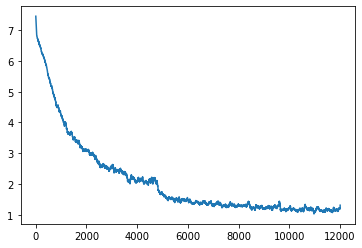

In [ ]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

# checkpoint = torch.load(checkpoints + "_efficientNetcheckpoint-10.pkl")
# losses = checkpoint['losses']
plt.plot(smooth(losses,50))

In [ ]:
print("Current accuracy of efficientNet: %f" % accuracy(efficientNet, data['train']))

Current accuracy of efficientNet: 0.507702


In [12]:
# Load model from checkpoint
import torch.nn as nn
import torchvision.models as models
device = torch.device("cpu")

efficientNet =  models.efficientnet_v2_s(pretrained=True)
# num_ftrs = efficientNet.classifier.in_features
# efficientNet.classifier = torch.nn.Linear(efficientNet.classifier.in_features, 555)

num_ftrs = efficientNet.classifier[-1].in_features
efficientNet.classifier[-1] = nn.Linear(num_ftrs, 555)


state = torch.load(checkpoints + 'efficientNetVersion2_Scheckpoint-6.pkl', map_location=torch.device(device))
efficientNet.load_state_dict(state['net'])

predict(efficientNet, data['test'], checkpoints + "EfficientNetv2sPred.csv")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


# resnet152
*italicized text*

In [ ]:
import torchvision.models as models

device = torch.device("cuda")
resnet152 = torch.hub.load('pytorch/vision:v0.9.0', 'resnet152', pretrained=True)
resnet152.fc = nn.Linear(512, 555) # This will reinitialize the layer as well

losses = train(resnet152, data['train'], epochs=15, lr=.01, print_every=10, checkpoint_path=checkpoints + "resnet152")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


RuntimeError: ignored

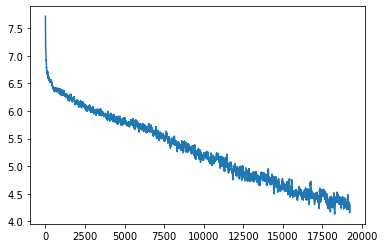

In [ ]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')
plt.plot(smooth(losses,50))

In [ ]:
print("Current accuracy of efficientNet: %f" % accuracy(resnet152, data['train']))

Current accuracy of efficientNet: 0.069602


In [ ]:
# Load model from checkpoint
resnet152 = torch.hub.load('pytorch/vision:v0.9.0', 'resnet152', pretrained=True)

state = torch.load(checkpoints + 'checkpoint-5.pkl')
resnet152.load_state_dict(state['net'])


predict(resnet152, data['test'], checkpoints + "ResNet152Pred.csv")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


# Resnet 50

In [ ]:
device = torch.device("cuda")
resnet50 = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 555) # This will reinitialize the layer as well
resnet50.to(device)
#uncomment if we have previously trained the model and have checkpoints in the drive
state = torch.load(checkpoints + "_resnet50" + 'checkpoint-12.pkl')
resnet50.load_state_dict(state['net'])

losses = train(resnet50, data['train'], epochs=13, start_epoch = 12, lr=.000001, print_every=50, decay=.0009, checkpoint_path=checkpoints + "_resnet50")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


[12,    50] loss: 1.046
[12,   100] loss: 1.083
[12,   150] loss: 1.029
[12,   200] loss: 1.052
[12,   250] loss: 1.042
[12,   300] loss: 1.040


### Create Loss Graph

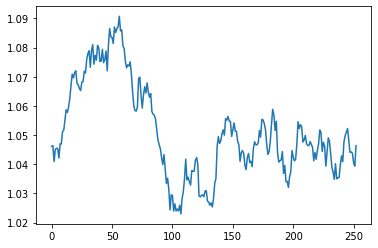

In [ ]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

# checkpoint = torch.load(checkpoints + "_resnet50" + 'checkpoint-9.pkl')
# losses = checkpoint['losses']
plt.plot(smooth(losses,50))

### Calculate the Accuracy

In [ ]:
print("Current accuracy of ResNet50: %f" % accuracy(resnet50, data['train']))

Current accuracy of ResNet50: 0.715264


### Create Predicion CSV

In [ ]:
# Load model from checkpoint
# resnet50 = models.__dict__['efficientnet_b0'](pretrained=True)
resnet50 = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 555) # This will reinitialize the layer as well
state = torch.load(checkpoints + "_resnet50" + 'checkpoint-13.pkl')
resnet50.load_state_dict(state['net'])


predict(resnet50, data['test'], checkpoints + "ResNet50Pred4.csv")

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
